# 데이터 전처리(Sample Data)

In [1]:
import os 
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from tqdm.contrib import tzip

In [2]:
# raw_data를 불러와서 메모리에 올립니다
lst = os.listdir("gecko_drive")
coin_price_dict = {}
coin_marketcap_dict = {}
coin_volume_dict = {}
error_list = []

for file in tqdm(lst):
    try:
        df = pd.read_csv("gecko_drive/{}".format(file), index_col=0)
        coin_price_dict[file] = df[["prices"]]
        coin_marketcap_dict[file] = df[["market_caps"]]
        coin_volume_dict[file] = df[["total_volumes"]]

    except:
        error_list.append(file)
        print("{} Open Error!!".format(file))
        continue
print("Done... Error file is saved in error_list")

  2%|▏         | 30/1492 [00:00<00:04, 299.92it/s]

0x0.ai Open Error!!
Agoras Open Error!!
Calvaria Open Error!!


 12%|█▏        | 184/1492 [00:00<00:03, 369.15it/s]

DMM Open Error!!
Era7 Open Error!!
Float Protocol Open Error!!
Green Light.csv Open Error!!


100%|██████████| 1492/1492 [00:04<00:00, 361.07it/s]

Done... Error file is saved in error_list


In [3]:
# 데이터를 하나의 DataFrame으로 합쳐줍니다

# find the longest timeframe index
longest_index_price = max([df.index for df in coin_price_dict.values()], key=len)
longest_index_cap = max([df.index for df in coin_marketcap_dict.values()], key=len)
longest_index_vol = max([df.index for df in coin_volume_dict.values()], key=len)

# create a close dataframe with the longest timeframe index and columns "key1", "key2", "key3"
price_df = pd.DataFrame(index=longest_index_price, columns=coin_price_dict.keys())
market_cap_df = pd.DataFrame(index=longest_index_cap, columns=coin_marketcap_dict.keys())
volume_df = pd.DataFrame(index=longest_index_vol, columns=coin_volume_dict.keys())

for key, df in tqdm(coin_price_dict.items()):
    # use groupby and last to select the last value for each index
    df = df.astype("float64")
    price_df[key] = df.groupby(df.index).last().reindex(longest_index_price)

for key, df in tqdm(coin_marketcap_dict.items()):
    df2 = df.astype("float64")
    market_cap_df[key] = df2.groupby(df2.index).last().reindex(longest_index_cap)

for key, df in tqdm(coin_volume_dict.items()):
    df = df.astype("float64")
    volume_df[key] = df.groupby(df.index).last().reindex(longest_index_vol)

100%|██████████| 1485/1485 [00:13<00:00, 110.15it/s]


In [4]:
# Datetime으로 index를 변경
price_df.index = pd.to_datetime(price_df.index)
market_cap_df.index = pd.to_datetime(market_cap_df.index)
volume_df.index = pd.to_datetime(volume_df.index)

In [5]:
# 시총으로 weight를 계산
weight = market_cap_df.apply(lambda x: x / np.nansum(x), axis=1)

# 수익률 데이터프레임 생성
return_df = price_df.pct_change(7)

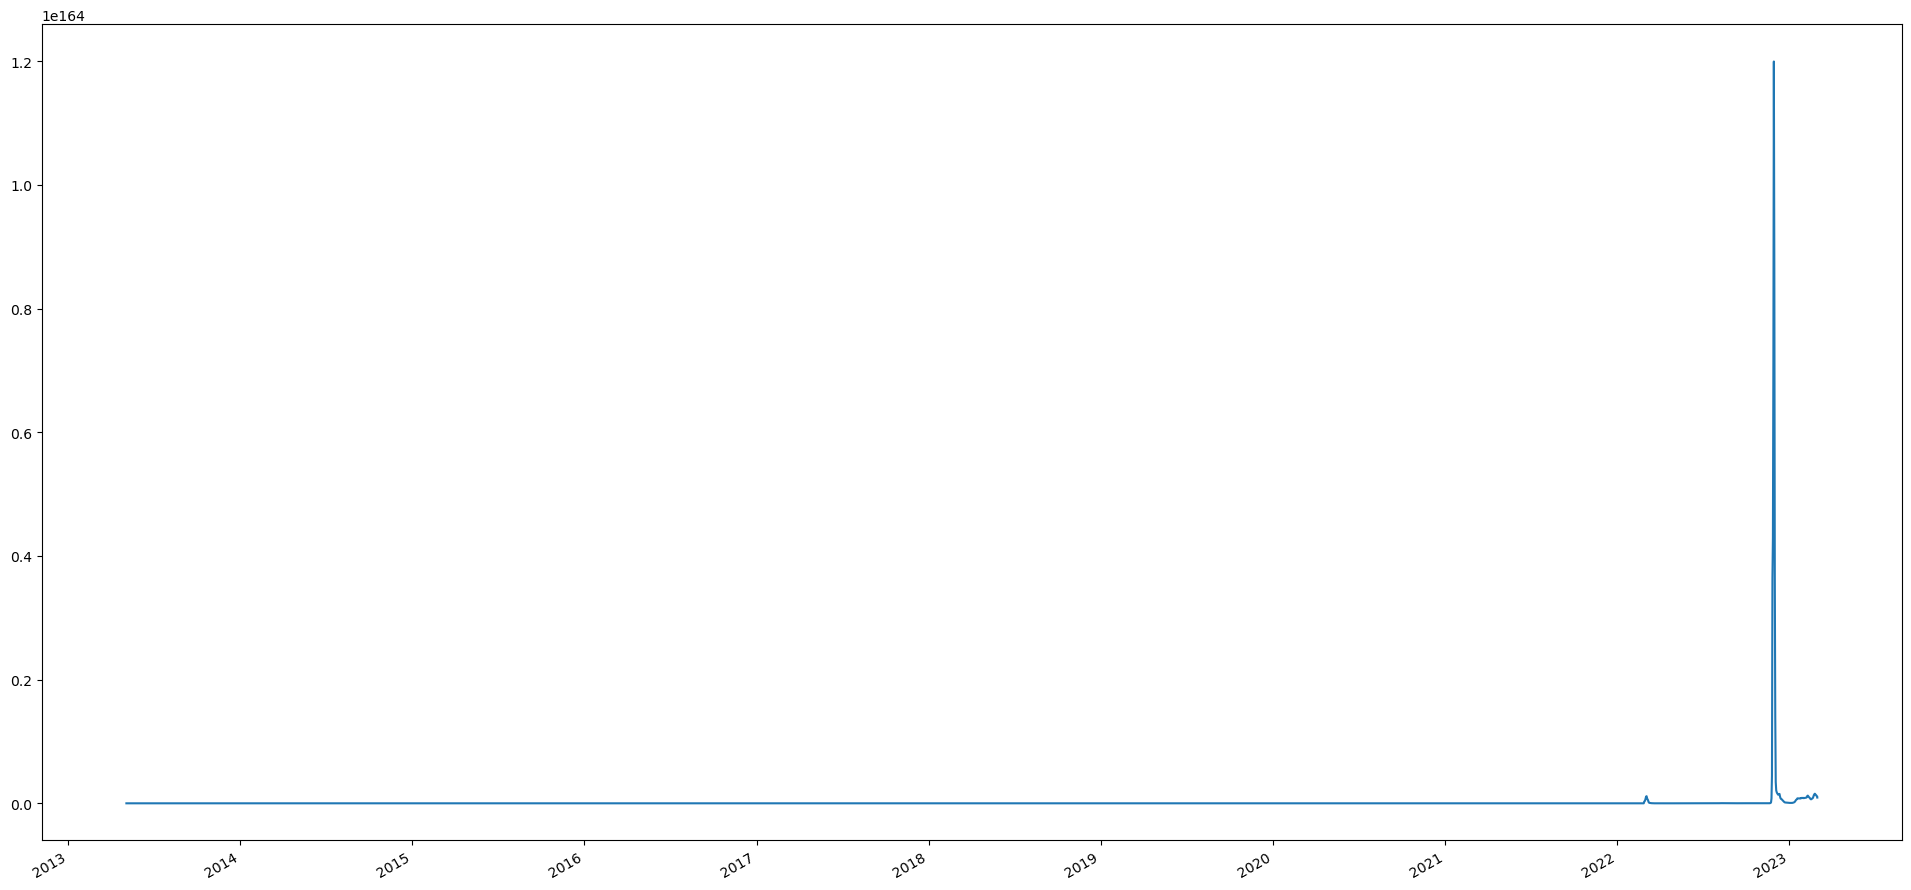

In [6]:
# weight * 리턴 (Without screening)
((return_df * price_df).mean(axis=1) + 1).cumprod().plot(figsize=(24,12));

In [7]:
# 시총으로 screening (1,000,000달러 이상)
screener = np.where(market_cap_df > 1_000_000, 1, np.nan)
screener_df = pd.DataFrame(screener, index=market_cap_df.index,
                           columns=market_cap_df.columns)

# 스크리닝 후, 스크린한 것들로만 시가총액 가중 weight를 구함
screened_weight = (screener_df * market_cap_df).apply(lambda x: x / np.nansum(x), axis=1)

In [8]:
# 상장된 코인 수가 중간에 0이 되는 데이터 문제 수정을 위해서
market_cap_df_ffill = market_cap_df.ffill()

# 시총으로 screening (1,000,000달러 이상)
screener = np.where(market_cap_df_ffill > 1_000_000, 1, np.nan)
screener_df = pd.DataFrame(screener, index=market_cap_df_ffill.index,
                           columns=market_cap_df_ffill.columns)

# 스크리닝 후, 스크린한 것들로만 시가총액 가중 weight를 구함
screened_weight = (screener_df * market_cap_df).apply(lambda x: x / np.nansum(x), axis=1)

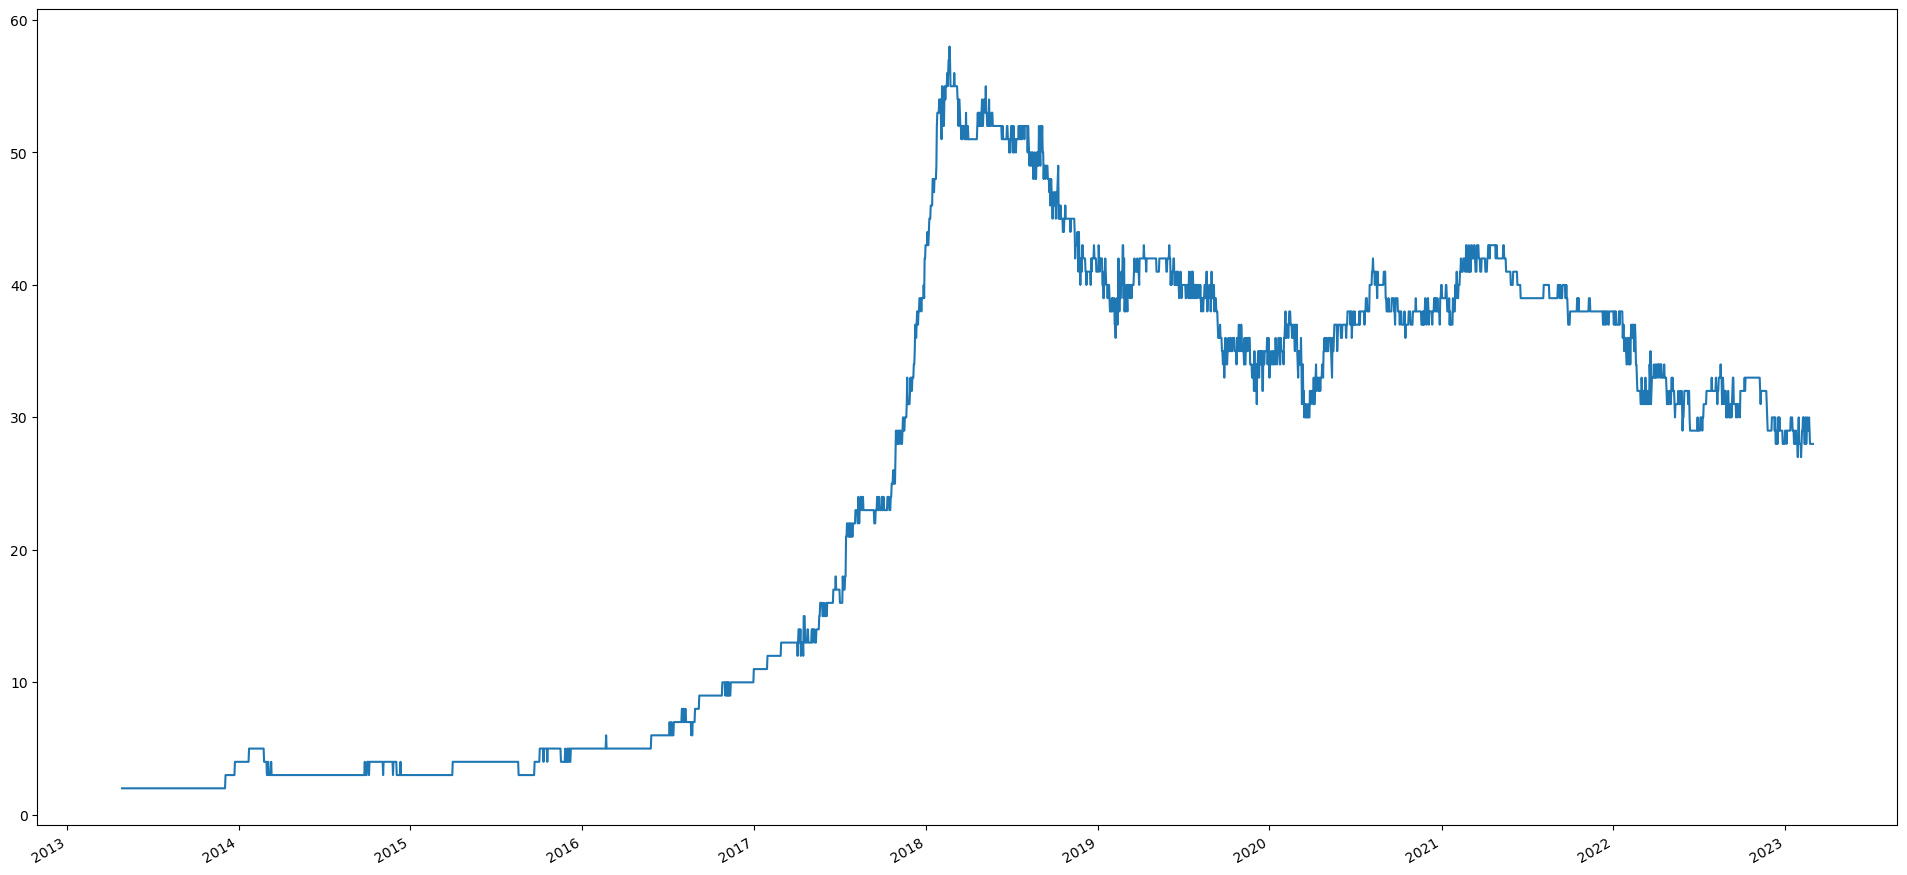

In [9]:
# ffill을 하고, 스크리닝 한 종목 수를 출력 (수익률 아님!!)
screener_df.count(axis=1).plot(figsize=(24,12));

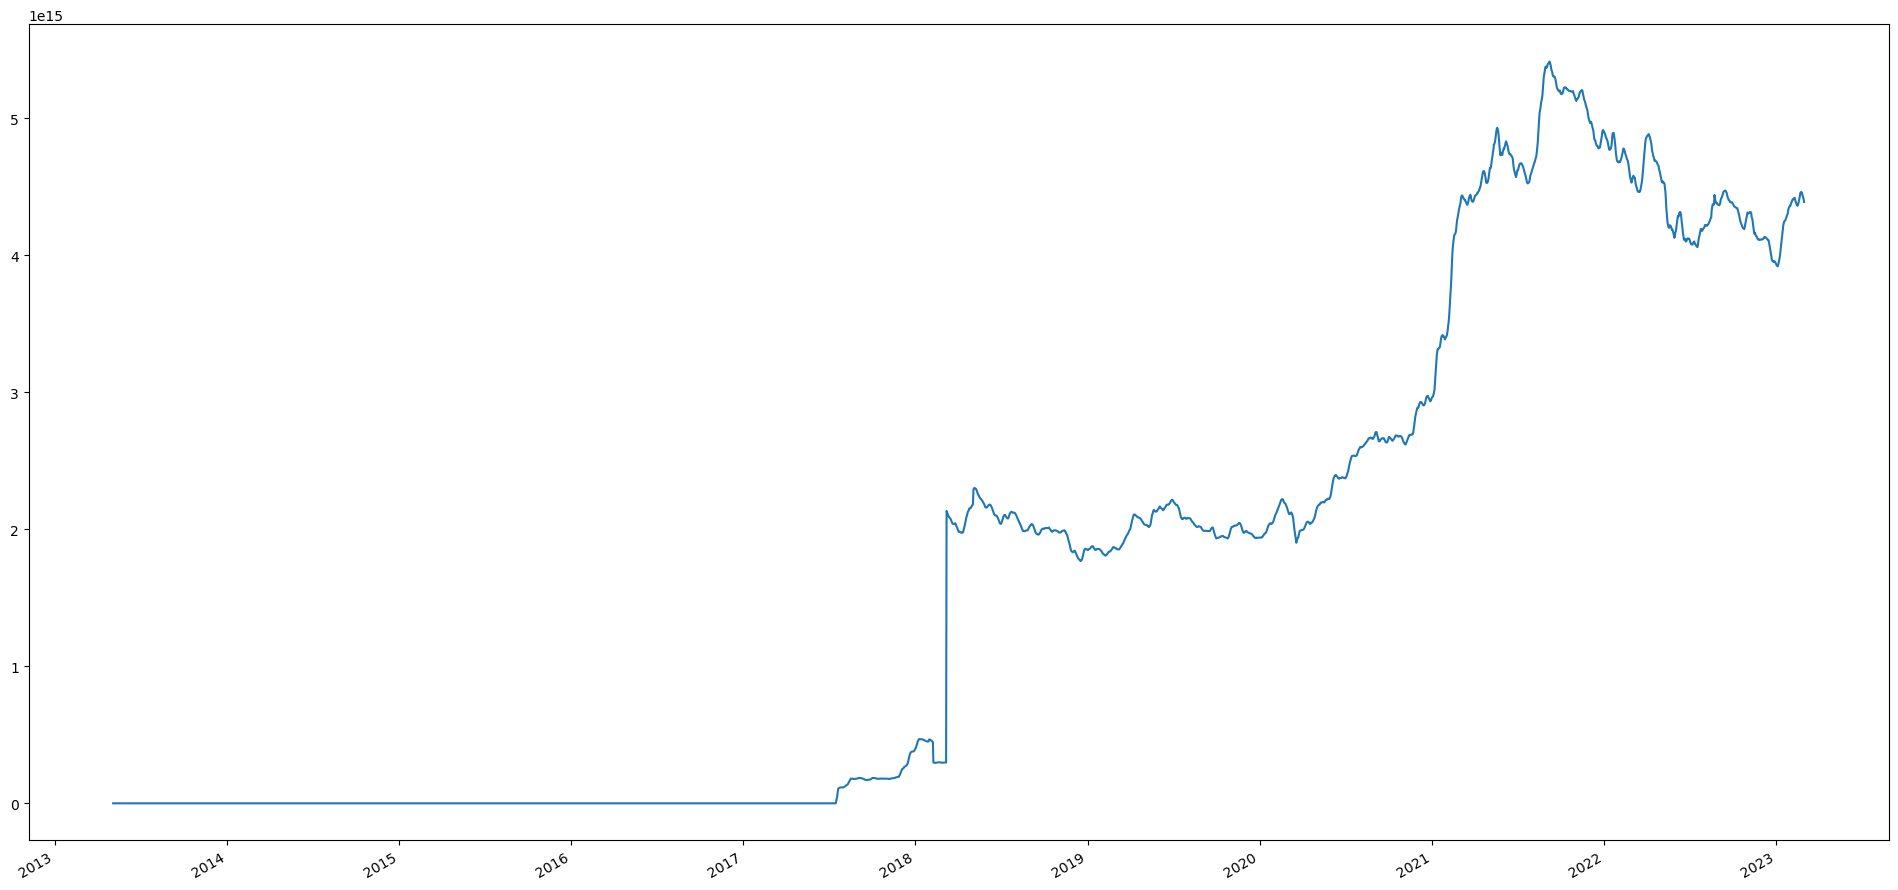

In [10]:
# 스크리닝하고, 시가총액으로 가중평균한 수익률
((return_df * screened_weight).mean(axis=1) + 1).cumprod().plot(figsize=(24,12));

Coingecko에서 데이터받기

In [1]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from api import CoinGecko, GoogleDrive

In [2]:
google = GoogleDrive("C://Jehyeon/Crypto_paper/crypto_paper/google.json/")

usage: ipykernel_launcher.py [-h] [--auth_host_name AUTH_HOST_NAME]
                             [--noauth_local_webserver]
                             [--auth_host_port [AUTH_HOST_PORT ...]]
                             [--logging_level {DEBUG,INFO,WARNING,ERROR,CRITICAL}]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9011 --control=9009 --hb=9008 --Session.signature_scheme="hmac-sha256" --Session.key=b"928a1030-9847-4a31-a888-0f79de123d9a" --shell=9010 --transport="tcp" --iopub=9012 --f=c:\Users\user\AppData\Roaming\jupyter\runtime\kernel-v2-17952EsWL1vr5ZBTf.json


In [3]:
lst = google.list_files("CoinGecko2")

In [4]:
len(lst)

12533

In [6]:
l = [key.replace(".","_").replace("*","").replace("/","") for key in lst.keys()]

# [.은 _로 /는 제거, *도 제거 

len(set(l))

12341

In [ ]:
sample = list(lst.keys())[:500]

In [ ]:
google.multi_download(
    folder_name= "CoinGecko2",
    file_loc="C:/Jehyeon/Crypto_paper/crypto_paper/gecko_drive/",
    file_name_list=list_convert
)

In [ ]:
gecko_lst = google.list_files("CoinGecko2")

In [ ]:
[key for key in gecko_lst.keys() if "Ethe" in key]

In [ ]:
l = os.listdir("gecko_drive")
len(l)

In [ ]:
gecko = CoinGecko()

In [ ]:
coin_lst = gecko.get_coin_list()
coin_lst[0]

In [ ]:
len(os.listdir("coingecko"))

In [ ]:
# 이렇게 반복문으로 받으면 된다 / 저장은 Name으로
error_list= []
dot_list = []

for coin_dict in tqdm(coin_lst[1800:5000]):
    time.sleep(5)
    try:
        df = gecko.get_coin_price_cap(coin_dict["id"])
        if "." in coin_dict["name"]:
            dot_list.append(coin_dict)
            continue
        df.to_csv("coingecko/{}.csv".format(coin_dict["name"]))
    except:
        error_list.append(coin_dict)
        continue

# dot_list랑 error_list확인해야함!!

In [ ]:
# 이렇게 반복문으로 받으면 된다 / 저장은 Name으로
for coin_dict in tqdm(dot_list):
    time.sleep(5)
    try:
        df = gecko.get_coin_price_cap(coin_dict["id"])
        if "." in coin_dict["name"]:
            name = str(coin_dict["name"]).replace(".","_")
        df.to_csv("coingecko/{}.csv".format(name))
    except:
        error_list.append(coin_dict)
        continue

# dot_list랑 error_list확인해야함!!

In [ ]:
# 그리고 바로 구글 드라이브에 업로드
from api import GoogleDrive
file_lst = os.listdir("coingecko")
google = GoogleDrive("C://Jehyeon/Crypto_paper/crypto_paper/google.json/")

google.multi_upload(
    folder_name= "CoinGecko2",
    file_loc="C:/Jehyeon/Crypto_paper/crypto_paper/coingecko/",
    file_name_list=file_lst[3800:]
)

In [ ]:
i = 0
google_dict = {}
google_lst = google.list_files("CoinGecko")

for k,v in google_lst.items():
    i+= 1
    if i > 12060:
        google_dict[k] = v
google.multi_download(
    folder_name= "CoinGecko",
    file_loc="C:/Jehyeon/Crypto_paper/crypto_paper/gecko_drive/",
    file_name_list=google_dict
)

In [ ]:
error_list

# 구글드라이브에서 데이터 받기

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from api import GoogleDrive

In [ ]:
google = GoogleDrive("C://Jehyeon/Crypto_paper/crypto_paper/google.json/")

In [ ]:
google_lst = google.list_files("CoinGecko")

In [ ]:
i = 0
google_dict = {}
for k,v in google_lst.items():
    i+= 1
    if i > 12060:
        google_dict[k] = v
google.multi_download(
    folder_name= "CoinGecko",
    file_loc="C:/Jehyeon/Crypto_paper/crypto_paper/gecko_drive/",
    file_name_list=google_dict
)

In [ ]:
google.multi_download(
    folder_name= "CoinGecko",
    file_loc="C:/Jehyeon/Crypto_paper/crypto_paper/gecko_drive/",
    file_name_list=google_dict
)

In [ ]:
# 구글드라이브 데이터와 로컬의 데이터가 일치하는 지 확인
google_key = list(google_lst.keys())
not_in = []

for file in os.listdir("coingecko"):
    if file not in google_key:
        not_in.append(file)
not_in

# 로컬 데이터 전처리

In [ ]:
# timestamp를 맞춰주는 과정
not_more_five = []
execpt_list = []
for file in tqdm(os.listdir("coingecko")):
    try:
        # Unix to datetime코드
        df = pd.read_csv("coingecko/{}".format(file), index_col=0)
        if df.shape[0] < 5:
            not_more_five.append(file)
            continue
        elif len(str(df.Time[0])) == 13:
            df.Time= pd.to_datetime(df.Time, unit="ms")
            df.Time.apply(lambda x: x.strftime("%Y-%m-%d"))
            df.to_csv("coingecko_pp/pp_{}".format(file))
        else:
            df.to_csv("coingecko_pp/{}".format(file))
    except:
        execpt_list.append(file)
        continue

In [ ]:
# 병국이가 원래 datetime으로 인덱스를 저장한 것만 불러와서 pp3에 저장해야한다
exception_list = []
ar = []
for file in tqdm(os.listdir("coingecko")):
    try:
        # Unix to datetime코드
        df = pd.read_csv("coingecko/{}".format(file), index_col=0)
        if df.shape[0] < 5:
            ar.append(file)
            continue
        elif str(df.index[0]).startswith("20"):
            df.to_csv("coingecko_pp3/{}".format(file))
    except:
        exception_list.append(file)

In [ ]:
exception_list

In [ ]:
len(ar)

In [ ]:
print(len(os.listdir("coingecko")))
print(len(os.listdir("coingecko_pp2")))
print(len(os.listdir("coingecko_pp3")))
# 이제 coingecko pp2와 coingecko pp3을 합치면된다

In [ ]:
for file in tqdm(os.listdir("coingecko_pp2")):
    df = pd.read_csv("coingecko_pp2/{}".format(file))
    if str(file).startswith("pp_"):
        file = str(file)[3:]
    df.to_csv("coingecko_pp3/{}".format(file))

In [ ]:
len(os.listdir("coingecko_pp3"))

# 데이터 전처리

In [ ]:
import os 
import pandas as pd
from tqdm import tqdm

In [ ]:
# 느린코드
return_df = pd.DataFrame()

for file in tqdm(os.listdir("coingecko_pp3")[:6000]):
    try:
        df = pd.read_csv("coingecko_pp3/{}".format(file), index_col=0)[["Price","Time"]]
        df.index = pd.to_datetime(df.Time)
        df = df.drop("Time",axis=1)
        col = list(return_df.columns)

        return_df = pd.merge(return_df,df,
                             left_index=True, right_index=True,
                             how="outer")
        col.append(str(file[:-4]))
        return_df.columns = col
    except:
        continue
return_df

In [ ]:
# 빠른코드
coin_dict = {}

for file in tqdm(os.listdir("coingecko_pp3")):
    try: # 내가 저장
        df = pd.read_csv("coingecko_pp3/{}".format(file), index_col=0)[["Time","Price","Marketcap"]]
        df.index = pd.to_datetime(df.Time)
        df.index = df.index.strftime("%Y-%m-%d")
        df.drop("Time", axis=1, inplace=True)
        df.columns = ["prices","market_caps"]
        coin_dict[file] = df
    except: # 병국이 저장
        df = pd.read_csv("coingecko_pp3/{}".format(file), index_col=0)[["prices","market_caps"]]
        df.index = pd.to_datetime(df.index)
        df.index = df.index.strftime("%Y-%m-%d")
        coin_dict[file] = df

In [ ]:
coin_price_dict = {}
for key,df in coin_dict.items():
    coin_price_dict[key] = df[["prices"]]

In [ ]:
# find the longest timeframe index
longest_index = max([df.index for df in coin_price_dict.values()], key=len)

# create a close dataframe with the longest timeframe index and columns "key1", "key2", "key3"
close_df = pd.DataFrame(index=longest_index, columns=coin_price_dict.keys())

for key, df in tqdm(coin_price_dict.items()):
    # use groupby and last to select the last value for each index
    close_df[key] = df.groupby(df.index).last().reindex(longest_index)

In [ ]:
print(os.listdir("coingecko_pp3"))

In [ ]:
#close_df["ethereum.csv"].plot()

# 회귀분석

In [ ]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [ ]:
# 데이터 불러오고 합치기
#coin_dict = {}
#
#file_list = os.listdir("data")
#
#for f in file_list:
#    print(f)
#    df = pd.read_csv("Data/" + f, index_col=0,
#                     parse_dates=True)["close"]
#    coin_dict[str(f)[:-4]] = df
#
#coin_df = pd.DataFrame(coin_dict)

In [ ]:
# 합친 데이터 불러오기
coin_df = pd.read_csv("all_coin_closeprice.csv", index_col=0,
                      parse_dates=True)

# 0은 NaN으로 변경
coin_df_with_nan = coin_df.replace(0,np.nan)

In [ ]:
# 주간 리턴 계산
save_dict = {}
week_start  = pd.date_range("2010-01-01","2022-12-31", freq="W")

for i in range(len(week_start)-1):
    w_start = week_start[i]
    w_end = week_start[i+1] - pd.Timedelta(days=1)
    tmp_df = coin_df_with_nan.loc[w_start:w_end] # 일주일치 데이터 추출
    w_rtn = tmp_df.apply(lambda x: (x[-1] - x[0]) / x[0] + 1, axis=0) # 일주일간 리턴 계산
    save_dict[w_start] = w_rtn

weekly_return = pd.DataFrame(save_dict).T

In [ ]:
# row별로 rank를 때려줌(수익률이 높을수록 0에 가까움) (NaN은 처리함)
weekly_return_rank = weekly_return.rank(axis=1, pct=True, 
                                        ascending=False, na_option="keep") 
weekly_return_rank

In [ ]:
# rank를 기준으로 screening한 DataFrame을 만든다
high = weekly_return_rank.apply(lambda x: np.where(x < 1/3, 1, np.nan))
middle = weekly_return_rank.apply(lambda x: np.where(((x < 2/3) & (x >= 1/3)), 1, np.nan))
low = weekly_return_rank.apply(lambda x: np.where(x >= 2/3, 1, np.nan))

In [ ]:
# 분위수별 주간 리턴 구하기(평균처줌)
high_rtn = (weekly_return * high).mean(skipna=True, axis=1)
middle_rtn = (weekly_return * middle).mean(skipna=True, axis=1)
low_rtn = (weekly_return * low).mean(skipna=True, axis=1)

In [ ]:
# Sample기간 동안의 수익률 구하기 (기간을 길게 잡으니 inf가 뜸)
a = high_rtn.loc["2020":"2022"].cumprod()
b = middle_rtn.loc["2020":"2022"].cumprod()
c = low_rtn.loc["2020":"2022"].cumprod()

In [ ]:
def do_regression(df, t):
    '''t만큼 시차를 가진 regression'''
    tmp_df = df.copy()
    y = tmp_df.shift(-t)
    concat = pd.concat([tmp_df, y], keys=["return","return_"+str(t)], axis=1) \
               .dropna()
    model = sm.OLS(concat["return_"+str(t)], concat["return"])
    result = model.fit(cov_type='HAC',cov_kwds={'maxlags':t}) #t-1인가?
    return result

In [ ]:
low_1 = do_regression(a, 1)
low_2 = do_regression(a, 2)
low_4 = do_regression(a, 4)

middle_1 = do_regression(b, 1)
middle_2 = do_regression(b, 2)
middle_4 = do_regression(b, 4)

high_1 = do_regression(c, 1)
high_2 = do_regression(c, 2)
high_4 = do_regression(c, 4)
#rt1_1.params, rt1_1.pvalues

In [ ]:
pd.DataFrame({"R_t_t+1": [low_1.params[0], middle_1.params[0], high_1.params[0]],
              "R_t_t+2": [low_2.params[0], middle_2.params[0], high_2.params[0]],
              "R_t_t+4": [low_4.params[0], middle_4.params[0], high_4.params[0]]},
              index=["Low","Middle","Hogh"])